# 10.1 The Jackknife Estimate of Standard Errors

### Setup

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.collections import LineCollection
from statsmodels.nonparametric.smoothers_lowess import lowess

Load the data

In [3]:
kidney = pd.read_csv("../data/kidney.txt", delimiter=" ")

In [4]:
kidney.head()

,age,tot
0,18,2.44
1,19,3.86
2,19,-1.22
3,20,2.30
4,21,0.98


### Lowess model

Create main lowess predictions

The `lowess` function returns an N x 2 Numpy array with x-values in the 0th column and y-values (fit values) in the 1st column

In [5]:
low_preds = lowess(kidney.tot, kidney.age, frac=1/3.0)

In [6]:
low_preds[:5]

array([[18.        ,  2.24792193],
       [19.        ,  1.95243881],
       [19.        ,  1.95243881],
       [20.        ,  1.65762652],
       [21.        ,  1.36364605]])

Below we'll create jackknife and bootstrap estimates at the ages 20, 30, ..., 80. We'll use `interp1d` to interpolate these values

In [7]:
ages = np.array(list(range(20, 90, 5)))

In [8]:
n_ages = ages.shape[0]
n_obs = kidney.shape[0]

### Jackknife estimates

In [9]:
low_jacks = []
for i in range(n_obs):
    jack_tot = np.concatenate((kidney.tot[:i], kidney.tot[i + 1:]))
    jack_age = np.concatenate((kidney.age[:i], kidney.age[i + 1:]))
    new_preds = lowess(jack_tot, jack_age, frac=1/3.0)
    low_jacks.append(new_preds)

In [10]:
# interpolate lowess predictions for age = 20, 30, ..., 80
jack_decs = np.zeros((n_ages, n_obs))
for i, pred in enumerate(low_jacks):
    # interp1d seems to have trouble with non-unique values
    pred = np.unique(pred, axis=0)
    # create an interpolator and collect each lowess's predictions
    interpolate = interp1d(pred[:, 0], pred[:, 1], fill_value="extrapolate", assume_sorted=True)
    jack_decs[:, i] = interpolate(ages)

# get estimate of theta
theta = jack_decs.mean(axis=1)

# get standard deviation for each age
jack_var = ((jack_decs - theta[:, None])**2).sum(axis=1) * (n_obs - 1) / n_obs
jack_sds = np.sqrt(jack_var)

### Boostrap estimates

This code is copied from section 1.1

Create 250 bootstrap samples of the lowess predictions

In [11]:
n_boots = 500

In [12]:
low_boots = []
for i in range(n_boots):
    boot_data = kidney.sample(n=kidney.shape[0], replace=True)
    new_preds = lowess(boot_data.tot, boot_data.age, frac=1/3.0)
    low_boots.append(new_preds)

Get bootstrap standard deviation as an estimate of standard error

In [13]:
# interpolate lowess predictions for age = 20, 30, ..., 80
boot_decs = np.zeros((n_ages, n_boots))
for i, pred in enumerate(low_boots):
    # interp1d seems to have trouble with non-unique values
    pred = np.unique(pred, axis=0)
    # create an interpolator and collect each lowess's predictions
    interpolate = interp1d(pred[:, 0], pred[:, 1], fill_value="extrapolate", assume_sorted=True)
    boot_decs[:, i] = interpolate(ages)

# get standard deviation for each age
boot_var = np.var(boot_decs, axis=1, ddof=1)
boot_sds = np.sqrt(boot_var)

### Figure 10.1

First, collect info for s.e. lines

In [14]:
# interpolate the original lowess points for age = 20, 30, ..., 80 
interpolate = interp1d(
    low_preds[:, 0],
    low_preds[:, 1],
    fill_value="extrapolate",
    assume_sorted=True
)

jack_se_lines = LineCollection(
    [
        [[age + 0.3, interpolate(age) - 2 * se], [age + 0.3, interpolate(age) + 2 * se]]
        for age, se in zip(ages, jack_sds)
    ],
    color="b",
    linestyle="--",
)

boot_se_lines = LineCollection(
    [
        [[age - 0.3, interpolate(age) - 2 * se], [age - 0.3, interpolate(age) + 2 * se]]
        for age, se in zip(ages, boot_sds)
    ],
    color="r",
)

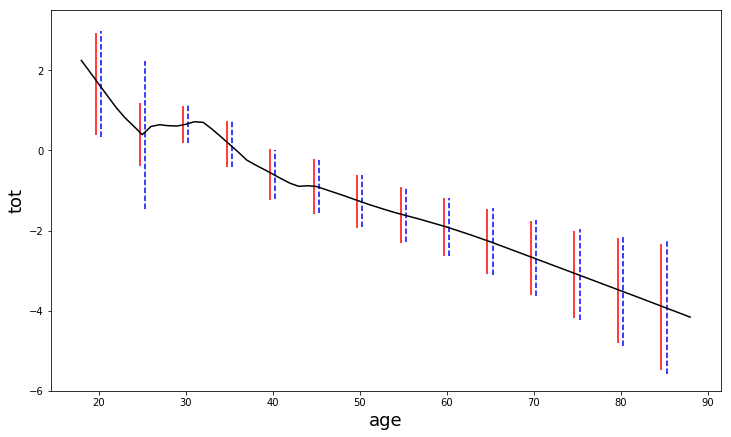

In [15]:
fig, ax = plt.subplots(figsize=(12, 7))

#ax.scatter(kidney.age, kidney.tot)
ax.plot(low_preds[:, 0], low_preds[:, 1], color="k")
ax.add_collection(jack_se_lines)
ax.add_collection(boot_se_lines)

ax.set_xlabel("age", size=18)
ax.set_ylabel("tot", size=18)

ax.set_ylim(-6, 3.5);